
1.   Reed-solomon ec for test cases 7, 10, 13, 15
2.   Differentiate between v1 and v3 without depending on module size
3.   Identify that test case 2, 6, 14 are warped and straighten them into a square
4.   Decode v3 for test case 15, 16
5.   mighty finger has alphanumeric encoding type don't know if i should invest time in alterring to fit it






In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def calculate_shift_left(image):
    counts_until_first_black_pixel = []
    current_counter = 0
    index = 0
    for row in image:
        while  index < len(row) and row[index] != 0:
            current_counter += 1
            index += 1
        index = 0
        if current_counter == len(row):
            continue
            
        else:
            counts_until_first_black_pixel.append(current_counter) 

        current_counter = 0
    return counts_until_first_black_pixel

def calculate_shift_up(image):
    counts_until_first_black_pixel = []
    current_counter = 0
    index = 0
    for col in image.T:
        while  index < len(col) and col[index] != 0:
            current_counter += 1
            index += 1
        index = 0
        if current_counter == len(col):
            continue
            
        else:
            counts_until_first_black_pixel.append(current_counter) 

        current_counter = 0
    return counts_until_first_black_pixel

def calculate_shift_right(image):
    counts_until_first_black_pixel = []
    current_counter = 0
    index = image.shape[1] - 1
    for row in image:
        while  index >= 0 and row[index] != 0:
            current_counter += 1
            index -= 1
        index = image.shape[1] - 1
        if current_counter == len(row):
            continue
            
        else:
            counts_until_first_black_pixel.append(current_counter) 

        current_counter = 0
    return counts_until_first_black_pixel

def calculate_shift_down(image):
    counts_until_first_black_pixel = []
    current_counter = 0
    index = image.shape[0] - 1
    for col in image.T:
        while  index >= 0 and col[index] != 0:
            current_counter += 1
            index -= 1
        index = image.shape[1] - 1
        if current_counter == len(col):
            continue
            
        else:
            counts_until_first_black_pixel.append(current_counter) 

        current_counter = 0
    return counts_until_first_black_pixel


def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    if pad_width[1] != 0: 
        vector[-pad_width[1]:] = pad_value

def even_quiet_zone(image):
    left = np.min(calculate_shift_left(image))
    right = np.min(calculate_shift_right(image))
    up = np.min(calculate_shift_up(image))
    down = np.min(calculate_shift_down(image))

    maximum_width = max([left, right, up, down])

    top_pad = maximum_width - up
    bottom_pad = maximum_width - down
    left_pad = maximum_width - left
    right_pad = maximum_width - right

    return np.pad(image, ((top_pad, bottom_pad), (left_pad, right_pad)), pad_with, padder=255)

In [3]:
def check_pattern(cells):
    """
    Check if the mean value of each cell in cells is within a tolerance of the corresponding value in the pattern.
    """
    pattern = [0, 255, 0, 0, 0, 255, 0]  # 1:1:3:1:1 pattern
    tolerance = 100
    results = [abs(int(np.mean(cell)) - pat) <= tolerance for cell, pat in zip(cells, pattern)]
    return all(results)

def rotate_image(image, degrees):
    return np.rot90(image, degrees // 90)

def check_valid_format(og, qr_cells, grid_cells_num, grid_cell_size):
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    ecl = [int(not(c)) for c in qr_cells_numeric[19:21, 8]]
    mask = [int(not(c)) for c in qr_cells_numeric[18:15:-1, 8]]
    fec = np.concatenate(([qr_cells_numeric[15, 8]], [qr_cells_numeric[14, 8]], qr_cells_numeric[8, 13:21][::-1]))  # Reverse to get from col 20 to col 13
    fec = [int(not(c)) for c in fec]

    ecl_check = [int(not(c)) for c in qr_cells_numeric[8, :2]]
    mask_check = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
    fec_check = np.concatenate(([qr_cells_numeric[8, 5]], [qr_cells_numeric[8, 7]], qr_cells_numeric[7:9,8][::-1], qr_cells_numeric[0:6,8][::-1]))
    fec_check = [int(not(c)) for c in fec_check]

    print(ecl + mask + fec == ecl_check + mask_check + fec_check)
    if not (ecl + mask + fec == ecl_check + mask_check + fec_check):
        revert = rotate_image(qr_cells, 270)
        return cv2.flip(og, 1).reshape((grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size)).swapaxes(1, 2)
    else:
        return qr_cells

def correct_orientation(og, qr_cells, grid_cells_num, grid_cell_size):
    """
    Correct the orientation of the QR code by checking the patterns in the corners and rotating if necessary.
    """
    # Check patterns in the corners
    bottom_right = qr_cells[grid_cells_num - 4, -7:], qr_cells[-7:, grid_cells_num-4]
    top_right = qr_cells[3, -7:], qr_cells[:7, grid_cells_num-4]
    bottom_left = qr_cells[grid_cells_num-4, :7], qr_cells[-7:, 3]


    # If the bottom right corner does not match the pattern, the QR code is in the correct orientation
    if not any(map(check_pattern, bottom_right)):
        return qr_cells

    # If all corners match the pattern, rotate 180 degrees
    if all(map(check_pattern, top_right + bottom_left)):
        return rotate_image(qr_cells, 180)

    # If the top right and bottom right corners match the pattern, rotate 270 degrees
    if all(map(check_pattern, top_right + bottom_right)):
        rotated = rotate_image(qr_cells, 90)
        return check_valid_format(og, rotated, grid_cells_num, grid_cell_size)
        

    # If the bottom left and bottom right corners match the pattern, rotate 90 degrees
    if all(map(check_pattern, bottom_left + bottom_right)):
        return rotate_image(qr_cells, 270)

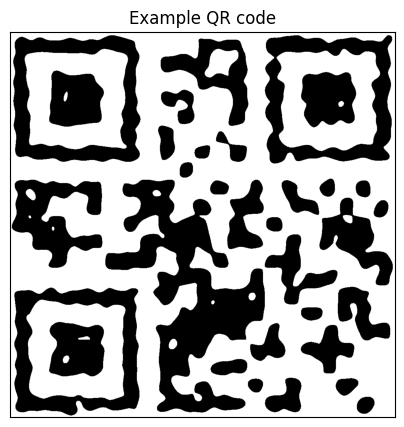

In [4]:
img = cv2.imread("./preprocessed_images/output_12.png", cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.title('Example QR code')
plt.imshow(img, cmap='gray');

In [5]:
# # gotta find a new way to get the qr without the quiet zone
# start_row = -1
# start_col = -1
# end_row = -1
# end_col = -1
# 
# for row_index, row in enumerate(img):
#     for pixel in row:
#         if pixel != 255:
#             start_row = row_index
#             break
#     if start_row != -1:
#         break
# 
# for row_index, row in enumerate(img[::-1]):
#     for pixel in row:
#         if pixel != 255:
#             end_row = img.shape[0] - row_index
#             break
#     if end_row != -1:
#         break
# 
# for col_index, col in enumerate(cv2.transpose(img)):
#     for pixel in col:
#         if pixel != 255:
#             start_col = col_index
#             break
#     if start_col != -1:
#         break
# 
# 
# for col_index, col in enumerate(cv2.transpose(img)[::-1]):
#     for pixel in col:
#         if pixel != 255:
#             end_col = img.shape[1] - col_index
#             break
#     if end_col != -1:
#         break
# 
# 
# # Align the start and end rows and columns
# start_row, start_col = max(start_row, start_col), max(start_row, start_col)
# end_row, end_col = max(end_row, end_col), max(end_row, end_col)
# 
# # Ensure the difference between the start and end is divisible by 21
# diff_row = end_row - start_row
# diff_col = end_col - start_col
# 
# if diff_row % 21 != 0:
#     end_row -= diff_row % 21
# if diff_col % 21 != 0:
#     end_col -= diff_col % 21
# 
# 
# print(start_row, end_row, start_col, end_col)
# # 44 968 44 968

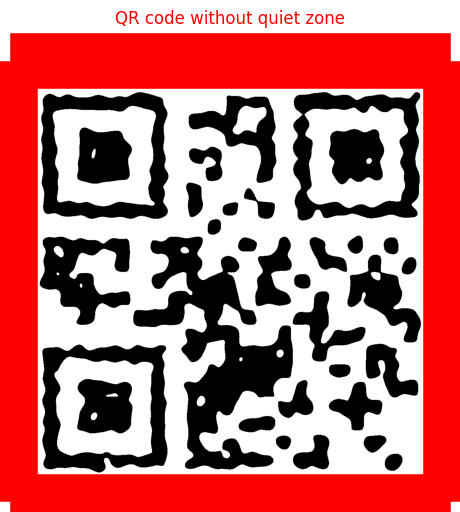

In [6]:
#qr_no_quiet_zone = img[start_row: end_row, start_col: end_col]
qr_no_quiet_zone = img
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
fig.get_axes()[0].spines[:].set_color('red');
fig.get_axes()[0].spines[:].set_linewidth(40);
fig.get_axes()[0].spines[:].set_position(("outward", 20))
plt.title('QR code without quiet zone', y = 1.15, color='red');
plt.imshow(qr_no_quiet_zone, cmap='gray');

In [7]:
grid_cells_num = 21
#grid_cell_size = round(math.sqrt((end_row - start_row)**2 / (grid_cells_num**2)))
grid_cell_size = round(math.sqrt((qr_no_quiet_zone.shape[0])**2 / (grid_cells_num**2)))

# ...into grid cells
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)
print(qr_cells.shape)

(21, 21, 50, 50)


In [8]:
corrected_qr = correct_orientation(qr_no_quiet_zone, qr_cells, grid_cells_num, grid_cell_size)

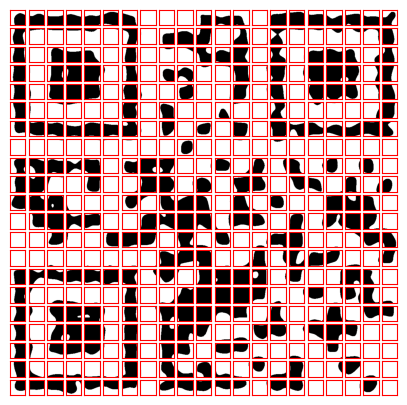

In [9]:
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(corrected_qr[i][j], cmap="gray", vmin=0, vmax=255)
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        col.spines[:].set_color('red')

In [10]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(corrected_qr):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)

print(qr_cells_numeric)

[[1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1]
 [0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0]
 [0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0]
 [0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0]
 [0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1]
 [0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1]
 [0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 0 1]
 [1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1]
 [1 1 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1]
 [0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1]
 [0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1]
 [0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1]
 [1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1]]


## Information extraction

![Meaning of format information.](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/QR_Format_Information.svg/640px-QR_Format_Information.svg.png)
> *Meaning of format information.*

### Error correction level

In [11]:
# We want row #8
# qr_cells_numeric[8]
qr_cells_numeric[19:21, 8]

array([0, 0], dtype=uint8)

In [12]:
# The last two bits determine the error correction level
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.
ecl = [int(not(c)) for c in qr_cells_numeric[19:21, 8]]  # We'll read the ecl from the bottom locator instead
# Why "not"? Because the standard uses '1's for black and '0's for white
#
# "A dark module is a binary one and a light module is a binary zero."
#  - ISO/IEC 18004:2000(E)
#
# In image processing, we use them the other way.. Hence the inversion
print(ecl)


[1, 1]


### Mask pattern

In [13]:
# Dictionary of all masks and their equivalent formulae
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}

# Same row as above, the three cells after the ecl cells (converted to a string)
# We'll read the mask pattern from the three bits before the ecl in col 8
mask = [int(not(c)) for c in qr_cells_numeric[18:15:-1, 8]]
mask_str = ''.join([str(c) for c in mask])
print(mask_str)

111


### Format error correction

In [14]:
# Same row as above, but we want cells #5 and #7 (#6 is always set to 0),
#  followed by column #8 from cell #0 in it to cell #7 (and skipping #6)
# fec = []
# fec.append(qr_cells_numeric[8, 5])
# fec.append(qr_cells_numeric[8, 7])
# fec.extend(qr_cells_numeric[0:6, 8])
# fec.extend(qr_cells_numeric[7:9, 8])
# fec = [int(not(c)) for c in fec]
# print(fec)

# We'll get #15, #14 from col 8 since #13 is always black
# We'll also get row 8 from last col to col 13
fec = []
fec.append(qr_cells_numeric[15, 8])
fec.append(qr_cells_numeric[14, 8])
fec.extend(qr_cells_numeric[8, 13:21][::-1])  # Reverse to get from col 20 to col 13
fec = [int(not(c)) for c in fec]
print(fec)


[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


In [15]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

[1, 1] [1, 1, 1] [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


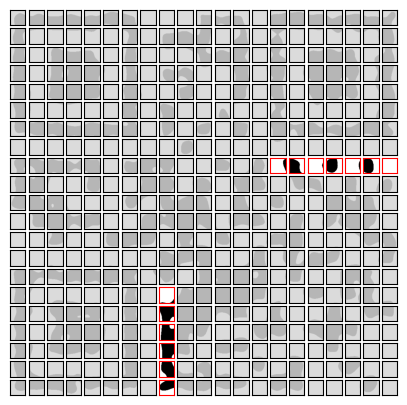

In [16]:
# Let's cross-check with our example
# _, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
# for i, row in enumerate(axes):
#     for j, col in enumerate(row):

#         col.get_xaxis().set_visible(False)
#         col.get_yaxis().set_visible(False)
#         if (i == 8 and j <= 8) or (i <= 8 and j == 8):
#             if (i != 6) and (j != 6):
#                 col.imshow(corrected_qr[i][j], cmap="gray", vmin=0, vmax=255)
#                 col.spines[:].set_color('red')
#                 continue
#         col.imshow(corrected_qr[i][j], cmap="gray", vmin=-1275, vmax=510)


# Plot the new format info
_, axes = plt.subplots(grid_cells_num, grid_cells_num, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):

        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)
        if (i in range(15, grid_cells_num) and j == 8) or (i == 8 and j in range(14, grid_cells_num)):
            col.imshow(corrected_qr[i][j], cmap="gray", vmin=0, vmax=255)
            col.spines[:].set_color('red')
            continue
        col.imshow(corrected_qr[i][j], cmap="gray", vmin=-1275, vmax=510)

In [17]:
# However..... You need to XOR that with the "format mask": 101010000010010
ecl[0] ^= 1
mask[0] ^= 1
mask[2] ^= 1
fec[5] ^= 1
fec[8] ^= 1

# And now we print...
print(ecl, mask, fec)

[0, 1] [0, 1, 0] [0, 1, 0, 1, 0, 0, 0, 1, 1, 1]


## Data extraction

![Message placement within a Ver 1 QR symbol (21×21).](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/QR_Character_Placement.svg/640px-QR_Character_Placement.svg.png)
> *Message placement within a Ver 1 QR symbol (21×21). Example from wikipedia, encoded QR message is www.wikipedia.org*

In [18]:
# Before we proceed, let's write a function for masking to make our lives easier
UP, UP_ENC, DOWN, CW, CCW = range(5)  # A rather old-fashioned pythonic "Enum"

def apply_mask(data_start_i, data_start_j, direction):
    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''
    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))

    return result[:4] if direction == UP_ENC else result

### Data encoding

In [19]:
enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
print(enc)

[0, 1, 0, 0]


### Data length

In [20]:
length = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
print(length)

[0, 0, 0, 0, 1, 1, 0, 1]


### Data extraction

In [21]:
#result
data_starting_indices = [
    [grid_cells_num-7, grid_cells_num-1, UP],
    [grid_cells_num-11, grid_cells_num-1, CCW],
    [grid_cells_num-10, grid_cells_num-3, DOWN],
    [grid_cells_num-6, grid_cells_num-3, DOWN],
    [grid_cells_num-2, grid_cells_num-3, CW],
    [grid_cells_num-3, grid_cells_num-5, UP],
    [grid_cells_num-7, grid_cells_num-5, UP],
    [grid_cells_num-11, grid_cells_num-5, CCW],
    [grid_cells_num-10, grid_cells_num-7, DOWN],
    [grid_cells_num-6, grid_cells_num-7, DOWN],
    [grid_cells_num-2, grid_cells_num-7, CW],
    [grid_cells_num-3, grid_cells_num-9, UP],
    [grid_cells_num-7, grid_cells_num-9, UP],
    [grid_cells_num-11, grid_cells_num-9, UP],
    [grid_cells_num-16, grid_cells_num-9, UP],
    [grid_cells_num-20, grid_cells_num-9, CCW],
    [grid_cells_num-19, grid_cells_num-11, DOWN],
    [grid_cells_num-14, grid_cells_num-11, DOWN],
    [grid_cells_num-12, grid_cells_num-11, DOWN],
    [grid_cells_num-8, grid_cells_num-11, DOWN], # this is E2
    [grid_cells_num-4, grid_cells_num-11, DOWN], # e3
    [grid_cells_num-12, grid_cells_num-13, UP], # e4
    [grid_cells_num-12, grid_cells_num-16, DOWN], #e5
    [grid_cells_num-12, grid_cells_num-18, UP], #e6
    [grid_cells_num-12, grid_cells_num-20, DOWN] #e7


]
# array 3la b3dha
# check 3la el enc
# check 3la el length
# 7wl mn bin le alpha
ans = ''
for a, b, d in data_starting_indices:
    bits = apply_mask(a, b, d)
    bit_string = ''.join([str(bit) for bit in bits])
    if bit_string[:4] == "0000":
        print(f'{bit_string[:4]} = 0 (NULL TERMINATOR)')
        break
    ans += chr(int(bit_string, 2)) # converts to binary to int, then to ASCII
    print(f'{bit_string} = {ans[-1]}')

print(f'\nDecoded string: {ans}')

01101101 = m
01000001 = A
01101100 = l
00110110 = 6
00100000 =  
01110111 = w
00100000 =  
01100110 = f
01100101 = e
01101100 = l
00101110 = .
01100101 = e
01101100 = l
0000 = 0 (NULL TERMINATOR)

Decoded string: mAl6 w fel.el
